In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

import utils

/home/t.desilva/.conda/envs/myEnv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device name:', torch.cuda.get_device_name(), '\n')

Device name: NVIDIA A100-SXM4-80GB 



In [3]:
traj = utils.read_traj(xtc_='../../Storage/Data/00.xtc', top_='../../Storage/Data/system.pdb')

In [4]:
batch_size = 128

traj_dl = DataLoader(traj, batch_size=batch_size, shuffle=True, drop_last=True)
# norm_traj_dl = DataLoader(utils.minMaxScale(traj), batch_size=batch_size, shuffle=True, drop_last=True) # modified to be in range(0,1)

In [5]:
# # Used to check output image dimensions of each layer

# conv1 = nn.Conv2d(1, 4096, kernel_size=(1,3))
# input_ = torch.rand(16, 1, 1, 3)

# print(conv1(input_).shape)

In [6]:
class AE(nn.Module):
    def __init__(self, n_channels=4096, n_atoms = 127, latent_dim=20):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_atoms = n_atoms
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            ##(N,1,n_atoms,03)
            nn.Conv2d(1,n_channels,kernel_size=(n_atoms,1), bias=True), #(N,4096,1,3)
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(n_channels),
            
            nn.Conv2d(n_channels,n_channels//4,kernel_size=(1,3), bias=True), #(N,1024,1,1)
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(n_channels//4),
            
            nn.Flatten(),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            #(N,latent_dim,1,1)
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Unflatten(1,(1024,1,1)),
            
            nn.ConvTranspose2d(1024,n_channels,kernel_size=(1,3), bias=True), #(N,4096,1,3)
            nn.BatchNorm2d(n_channels),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.ConvTranspose2d(n_channels, 1, kernel_size=(n_atoms,1), bias=True) #(N, 1, n_atoms, 3)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AE().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

summary(model, input_size=(16, 1, 127, 3))

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [16, 1, 127, 3]           --
├─Sequential: 1-1                        [16, 20]                  --
│    └─Conv2d: 2-1                       [16, 4096, 1, 3]          524,288
│    └─LeakyReLU: 2-2                    [16, 4096, 1, 3]          --
│    └─BatchNorm2d: 2-3                  [16, 4096, 1, 3]          8,192
│    └─Conv2d: 2-4                       [16, 1024, 1, 1]          12,583,936
│    └─LeakyReLU: 2-5                    [16, 1024, 1, 1]          --
│    └─BatchNorm2d: 2-6                  [16, 1024, 1, 1]          2,048
│    └─Flatten: 2-7                      [16, 1024]                --
│    └─Linear: 2-8                       [16, 512]                 524,800
│    └─BatchNorm1d: 2-9                  [16, 512]                 1,024
│    └─LeakyReLU: 2-10                   [16, 512]                 --
│    └─Linear: 2-11                      [16, 256]        

In [8]:
def training_batch(data, model, optimizer):
    model.train()
    data = data.to(device)
    recon = model(data)
    loss = loss_function(recon, data)
    avg_RMSD = RMSD_(recon, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, avg_RMSD

In [9]:
def RMSD_(recon, x, reduce='mean'):
    avg_RMSD = 0.0
    x1 = recon.to(device).reshape(-1,recon.shape[2], 3)
    x2 = x.to(device).reshape(-1,recon.shape[2], 3)
    for i in range(len(x1)):
        avg_RMSD += torch.sqrt(torch.mean(torch.sum((x1[i] - x2[i])**2, axis=1)))
    if reduce == 'mean':
        return avg_RMSD/len(x1)
    if reduce == 'sum':
        return avg_RMSD

In [10]:
# calculate pair-wise distance matrices
def pairwise_distances(coordinates):
    coordinates = coordinates.reshape(batch_size, -1, 3)
    coordinates = torch.tensor(coordinates, requires_grad=True)
    """
    Calculates pairwise distances for a batch of 3N-dimensional coordinates.

    Args:
    coordinates: A PyTorch tensor of shape (B, N, 3) representing the x, y, z
    coordinates of N points in a batch of size B.

    Returns:
    A PyTorch tensor of shape (B, N, N) representing the pairwise distances
    for each set of coordinates in the batch.
    """

    # Calculate squared differences for each dimension
    diff_x = coordinates[:, :, 0][:, :, None] - coordinates[:, :, 0][:, None, :]
    diff_y = coordinates[:, :, 1][:, :, None] - coordinates[:, :, 1][:, None, :]
    diff_z = coordinates[:, :, 2][:, :, None] - coordinates[:, :, 2][:, None, :]
    
    # Calculate squared distances
    squared_distances = diff_x ** 2 + diff_y ** 2 + diff_z ** 2
    
    # Return the square root (Euclidean distance)
    return torch.sqrt(squared_distances)

In [11]:
def loss_function(recon, x):
    # criterion = nn.MSELoss(reduction='sum')
    rmsd = RMSD_(recon, x, reduce='sum')
    # distance_MSE = F.mse_loss(pairwise_distances(recon), pairwise_distances(x), reduction='mean')
    # RECON = F.mse_loss(recon, x, reduction='sum')
    # RECON = criterion(recon, x)
    # RECON = nn.CrossEntropyLoss(recon,x)
    return rmsd
    # return rmsd + distance_MSE**0.5

In [12]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 250

training_loss = []
RMSD = []

for epoch in range(n_epochs):
    training_losses = []
    RMSDs = []
    
    for data in traj_dl:
        data = data.reshape(-1,1,model.n_atoms,3).to(device)
        # org = org.reshape(-1,1,127,3).to(device)
        trng_batch_loss, avg_RMSD = training_batch(data, model, optimizer)
        training_losses.append(trng_batch_loss.item())
        RMSDs.append(avg_RMSD.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    rmsd_per_epoch = np.array(RMSDs).mean()
    
    training_loss.append(training_per_epoch_loss)
    RMSD.append(rmsd_per_epoch)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1:>3d}/{n_epochs}\t|\t Mean training loss: {training_per_epoch_loss:7.4f} \t|\t mean_RMSD = {rmsd_per_epoch:5.3f}  \n')

Epoch:  10/250	|	 Mean training loss: 24.3115 	|	 mean_RMSD = 0.190  

Epoch:  20/250	|	 Mean training loss: 19.0950 	|	 mean_RMSD = 0.149  

Epoch:  30/250	|	 Mean training loss: 16.4389 	|	 mean_RMSD = 0.128  

Epoch:  40/250	|	 Mean training loss: 14.8255 	|	 mean_RMSD = 0.116  

Epoch:  50/250	|	 Mean training loss: 14.1533 	|	 mean_RMSD = 0.111  

Epoch:  60/250	|	 Mean training loss: 13.1853 	|	 mean_RMSD = 0.103  

Epoch:  70/250	|	 Mean training loss: 12.8085 	|	 mean_RMSD = 0.100  

Epoch:  80/250	|	 Mean training loss: 12.2392 	|	 mean_RMSD = 0.096  

Epoch:  90/250	|	 Mean training loss: 11.9205 	|	 mean_RMSD = 0.093  

Epoch: 100/250	|	 Mean training loss: 11.7292 	|	 mean_RMSD = 0.092  

Epoch: 110/250	|	 Mean training loss: 11.2350 	|	 mean_RMSD = 0.088  

Epoch: 120/250	|	 Mean training loss: 11.3857 	|	 mean_RMSD = 0.089  

Epoch: 130/250	|	 Mean training loss: 10.6805 	|	 mean_RMSD = 0.083  

Epoch: 140/250	|	 Mean training loss: 10.4214 	|	 mean_RMSD = 0.081  

Epoch:

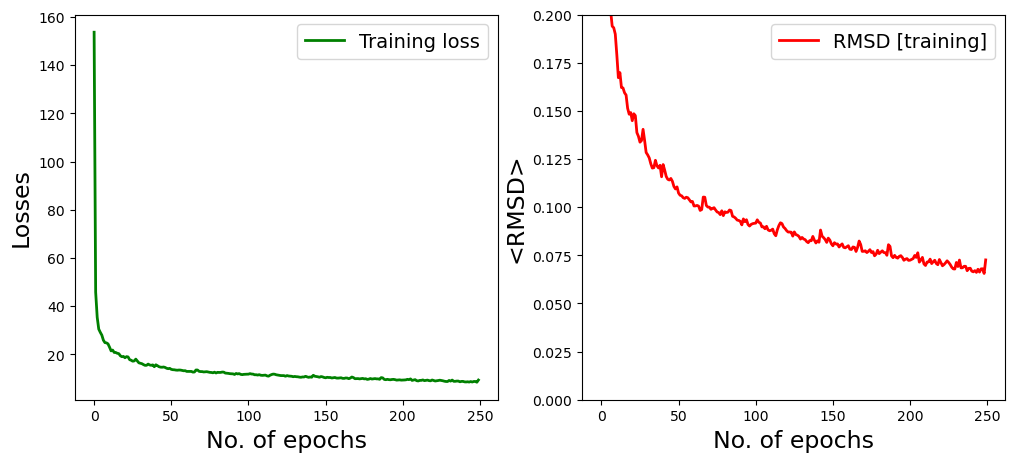

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(training_loss, 'g-', linewidth=2, label='Training loss')
ax[1].plot(RMSD, 'r-', linewidth=2, label='RMSD [training]')
# plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')

ax[0].set_xlabel('No. of epochs', fontsize=17)
ax[0].set_ylabel('Losses', fontsize=17)
ax[0].legend(fontsize=14)
ax[1].set_xlabel('No. of epochs', fontsize=17)
ax[1].set_ylabel('<RMSD>', fontsize=17)
ax[1].set_ylim(0,0.2)
ax[1].legend(fontsize=14);